In [44]:
import pandas as pd
import numpy as np

# from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
# from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
%matplotlib inline

## 1. IMPORTACIÓN DE LOS DATOS

#### Importamos los datos desde el .csv elaborado en el paquete data-preprocessing para estudiar los datos.

In [3]:
path = "../../../data-preprocessing/src/data_preprocessing/data/provisional_final_data.parquet"
data = pd.read_parquet(path=path).dropna().drop_duplicates()
data

,distrito,id,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion,fecha,hora,prec
0,3,1048,M30,1260.0,5.0,0.0,92.0,N,5.0,2021-12-01,00:00:00,"2,4"
1,3,1048,M30,1260.0,5.0,0.0,92.0,N,5.0,2021-12-01,00:15:00,"2,4"
2,3,1048,M30,1260.0,5.0,0.0,92.0,N,5.0,2021-12-01,00:30:00,"2,4"
3,3,1048,M30,1260.0,5.0,0.0,92.0,N,5.0,2021-12-01,00:45:00,"2,4"
4,3,1048,M30,1260.0,5.0,0.0,92.0,N,5.0,2021-12-01,01:00:00,"2,4"
...,...,...,...,...,...,...,...,...,...,...,...,...
1696108,3,11118,URB,68.0,0.0,4.0,0.0,N,14.0,2024-12-31,22:45:00,"0,0"
1696109,3,11118,URB,87.0,0.0,3.0,0.0,N,14.0,2024-12-31,23:00:00,"0,0"
1696110,3,11118,URB,76.0,0.0,3.0,0.0,N,13.0,2024-12-31,23:15:00,"0,0"
1696111,3,11118,URB,53.0,0.0,3.0,0.0,N,6.0,2024-12-31,23:30:00,"0,0"


In [4]:
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y-%m-%d')
data['year'] = data['fecha'].dt.year

In [10]:
# Filtrar las filas donde tipo_elem no sea 'C30'
data = data[data['tipo_elem'] != 'C30']

# Agrupar y contar
result = (
    data.groupby(['distrito', 'year', 'tipo_elem'])
               .size()
               .reset_index(name='num_muestras')
)

In [11]:
print(result)

   distrito  year tipo_elem  num_muestras
0         3  2021       M30         74971
1         3  2021       URB        339768
2         3  2022       M30         54278
3         3  2022       URB        321727
4         3  2023       M30         55826
5         3  2023       URB        365948
6         3  2024       M30         52665
7         3  2024       URB        366753


In [9]:
values_per_tipo_elem_distrito_centro = data.groupby(['tipo_elem', 'year'])['carga'].count()
values_per_tipo_elem_distrito_centro

tipo_elem  year
C30        2022     19292
           2023     20336
           2024     17718
M30        2021     74971
           2022     54278
           2023     55826
           2024     52665
URB        2021    339768
           2022    321727
           2023    365948
           2024    366753
Name: carga, dtype: int64

## 2. TRANSFORMACIÓN DE LOS DATOS

#### Estudiamos la presencia de valores nulos

In [12]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1631936 entries, 0 to 1696112
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   distrito             1631936 non-null  int64         
 1   id                   1631936 non-null  int64         
 2   tipo_elem            1631936 non-null  object        
 3   intensidad           1631936 non-null  float64       
 4   ocupacion            1631936 non-null  float64       
 5   carga                1631936 non-null  float64       
 6   vmed                 1631936 non-null  float64       
 7   error                1631936 non-null  object        
 8   periodo_integracion  1631936 non-null  float64       
 9   fecha                1631936 non-null  datetime64[ns]
 10  hora                 1631936 non-null  object        
 11  prec                 1631936 non-null  object        
 12  year                 1631936 non-null  int32         
dtypes:

#### Como se puede observar, las columnas ocupacion, vmed y error presentan valores nulos. Veamos cuántos valores nulos presenta cada columna.

In [13]:
null_values_ocupacion = data['ocupacion'].isnull().sum()
print(f"La columna null_values_ocupacion presenta {null_values_ocupacion} valores nulos")
null_values_vmed = data['vmed'].isnull().sum()
print(f"La columna null_values_vmed presenta {null_values_vmed} valores nulos")
null_values_error = data['error'].isnull().sum()
print(f"La columna null_values_error presenta {null_values_error} valores nulos")

La columna null_values_ocupacion presenta 0 valores nulos
La columna null_values_vmed presenta 0 valores nulos
La columna null_values_error presenta 0 valores nulos


#### A partir de la columna fecha vamos a obtener otras columnas: year, month, day, name_of_day, is_weekend, is_holiday y minutes_since_midnight.
#### En principio, el modelo que vamos a utilizar es un Random Forest Regressor. Cuando utilizamos este modelo, no nos tenemos que preocupar por relaciones cíclicas y además, maneja bien variables numéricas discretas y continuas. Es por ello, por lo que vamos a añadir una columna llamada minutes_since_midnight para capturar el momento del día.
#### Esto nos permitirá posteriormente saber en qué días se ha producido mayor congestión según el año.

In [14]:
data['hora'] = pd.to_datetime(data['hora'], format='%H:%M:%S')

data['year'] = data['fecha'].dt.year
data['month'] = data['fecha'].dt.month
data['day'] = data['fecha'].dt.day
data['day_of_the_week'] = data['fecha'].dt.weekday
data['is_weekend'] = data['day_of_the_week'].isin([5,6]).astype(int)
data['is_holiday'] = np.where(
    (data['day'].isin([6, 8, 25]))|
    ((data['year'] == 2024) & (data['day'] == 9)),
    1.0,
    0.0
    )
data['minuntes_since_midnight'] = (
    data['hora'].dt.hour * 60 +
    data['hora'].dt.minute).astype(float)

data.drop(columns=['fecha', 'hora'], inplace=True)
data

C:\Users\jacbj\AppData\Local\Temp\ipykernel_9168\4289032295.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hora'] = pd.to_datetime(data['hora'], format='%H:%M:%S')
C:\Users\jacbj\AppData\Local\Temp\ipykernel_9168\4289032295.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['year'] = data['fecha'].dt.year
C:\Users\jacbj\AppData\Local\Temp\ipykernel_9168\4289032295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,distrito,id,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion,prec,year,month,day,day_of_the_week,is_weekend,is_holiday,minuntes_since_midnight
0,3,1048,M30,1260.0,5.0,0.0,92.0,N,5.0,"2,4",2021,12,1,2,0,0.0,0.0
1,3,1048,M30,1260.0,5.0,0.0,92.0,N,5.0,"2,4",2021,12,1,2,0,0.0,15.0
2,3,1048,M30,1260.0,5.0,0.0,92.0,N,5.0,"2,4",2021,12,1,2,0,0.0,30.0
3,3,1048,M30,1260.0,5.0,0.0,92.0,N,5.0,"2,4",2021,12,1,2,0,0.0,45.0
4,3,1048,M30,1260.0,5.0,0.0,92.0,N,5.0,"2,4",2021,12,1,2,0,0.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696108,3,11118,URB,68.0,0.0,4.0,0.0,N,14.0,"0,0",2024,12,31,1,0,0.0,1365.0
1696109,3,11118,URB,87.0,0.0,3.0,0.0,N,14.0,"0,0",2024,12,31,1,0,0.0,1380.0
1696110,3,11118,URB,76.0,0.0,3.0,0.0,N,13.0,"0,0",2024,12,31,1,0,0.0,1395.0
1696111,3,11118,URB,53.0,0.0,3.0,0.0,N,6.0,"0,0",2024,12,31,1,0,0.0,1410.0


In [15]:
cols_to_convert = ['id', 'intensidad', 'carga', 'periodo_integracion', 'year', 'month', 'day', 'day_of_the_week', 'is_weekend']
data[cols_to_convert] = data[cols_to_convert].astype('float64')

if data['prec'].dtype != float:
    data['prec'] = data['prec'].str.replace(',', '.').astype(float)

data.info(verbose=True)

C:\Users\jacbj\AppData\Local\Temp\ipykernel_9168\496329682.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[cols_to_convert] = data[cols_to_convert].astype('float64')


<class 'pandas.core.frame.DataFrame'>
Index: 1631936 entries, 0 to 1696112
Data columns (total 17 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   distrito                 1631936 non-null  int64  
 1   id                       1631936 non-null  float64
 2   tipo_elem                1631936 non-null  object 
 3   intensidad               1631936 non-null  float64
 4   ocupacion                1631936 non-null  float64
 5   carga                    1631936 non-null  float64
 6   vmed                     1631936 non-null  float64
 7   error                    1631936 non-null  object 
 8   periodo_integracion      1631936 non-null  float64
 9   prec                     1631936 non-null  float64
 10  year                     1631936 non-null  float64
 11  month                    1631936 non-null  float64
 12  day                      1631936 non-null  float64
 13  day_of_the_week          1631936 non-null  floa

C:\Users\jacbj\AppData\Local\Temp\ipykernel_9168\496329682.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prec'] = data['prec'].str.replace(',', '.').astype(float)


#### La columna 'error' nos indica si ha habido al menos una muestra errónea o sustituida en el periodo de 15 minutos. Tiene 3 posibles valores:
#### - N: no ha habido errores ni sustituciones.
#### - E: los parámetros de calidad de alguna de las muestras integradas no son óptimos.
#### - S: alguna de las muestras recibidas era totalmente errónea y no se ha integrado.
#### Vamos a obtener los valores únicos presentes en dicha columna. Si hay un solo valor de los tres posibles, podemos eliminar la columna.

In [16]:
data['error'].unique()

array(['N', ''], dtype=object)

In [17]:
data.drop(columns='error', inplace=True)

C:\Users\jacbj\AppData\Local\Temp\ipykernel_9168\3782427630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns='error', inplace=True)


## 3. EXTRACCIÓN DE INFORMACIÓN RELEVANTE

### 3.1. COLUMNA TIPO_ELEM

#### Vamos a estudiar los datos, en primer lugar, atendiendo a la columna tipo_elem

#### De la información que se puede obtener del documento donde se explica la estructura del conjunto de datos del tráfico, sabemos que la carga no se calcula para la M30 y su valor es 0, salvo para algunos puntos de medida donde sí se realiza el cálculo de dicho parámetro. Veamos cuántos valores hay recogidos para tipo_elem == 'M30' y cuántos de ellos tienen el valor de carga == 0 y cuántos no.

In [30]:
query1 = (data['tipo_elem'] == 'M30')
m30_values = query1.sum()
print(f"Hay {m30_values} registros de tráfico recogidos para tipo_elem == 'M30'")

Hay 237740 registros de tráfico recogidos para tipo_elem == 'M30'


#### Veamos cuántos de esos valores presentan un valor de carga == 0:

In [31]:
query2 = ((data['tipo_elem'] == 'M30') &
          (data['carga'] == 0))
m30_zero_values = query2.sum()
print(f"Hay {m30_zero_values} registros de tráfico recogidos para tipo_elem == 'M30' en los que el valor de la carga es 0")

Hay 21397 registros de tráfico recogidos para tipo_elem == 'M30' en los que el valor de la carga es 0


#### Veamos ahora cuántos de esos valores presentan un valor de carga != 0:

In [32]:
query3 = ((data['tipo_elem'] == 'M30') &
          (data['carga'] != 0))
m30_non_zero_values = query3.sum()
print(f"Hay {m30_non_zero_values} registros de tráfico recogidos para tipo_elem == 'M30' en los que el valor de la carga es distinto de 0")

Hay 216343 registros de tráfico recogidos para tipo_elem == 'M30' en los que el valor de la carga es distinto de 0


In [33]:
percentage_m30_zero_values = m30_zero_values/m30_values*100
print(f"El {percentage_m30_zero_values:.2f}% de los registros de tráfico recogidos para tipo_elem == M30 tienen un valor de carga 0")

El 9.00% de los registros de tráfico recogidos para tipo_elem == M30 tienen un valor de carga 0


#### Por lo tanto, para la gran mayoría de los datos de tráfico recogidos por tipo_elem == 'M30', el valor de carga es distinto de 0

#### Necesitamos hacer ciertas comprobaciones respecto a algunas columnas, como por ejemplo vmed y carga ya que, como se especifica en la descripción del conjunto de datos en la página web del Ayuntamiento de Madrid, solo se recogen datos de vmed si tipo_elem es M30, por lo que tendremos muchos valores 0 para los valores de tipo_elem distintos de M30. 
#### A priori, si los valores de vmed son 0, cabe esperar que los valores de carga para dichos registros sean o muy bajos (porque no hay tráfico) o muy altos (hay mucho tráfico y por tanto congestión).
#### Comenzaremos estudiando tipo_elem == 'C30'

In [34]:
query4 = (data['tipo_elem'] == 'C30')
c30_values = query4.sum()
print(f"Hay {c30_values} registros de tráfico recogidos para tipo_elem == 'C30'")

Hay 0 registros de tráfico recogidos para tipo_elem == 'C30'


#### Estudiamos ahora cuántos de estos registros presentan valores de vmed == 0

In [35]:
query5 = ((data['tipo_elem'] == 'C30') &
    (data['vmed'] == 0))

c30_zero_vmed_values = query5.sum()
print(f"Hay {c30_zero_vmed_values} registros de tráfico recogidos para tipo_elem == 'C30' para los que vmed es 0")

Hay 0 registros de tráfico recogidos para tipo_elem == 'C30' para los que vmed es 0


#### Ahora, para estos valores calculamos cuáles presentan un valor de carga == 0.

In [36]:
query6 = ((data['tipo_elem'] == 'C30') &
    (data['vmed'] == 0) &
    (data['carga'] == 0))

c30_zero_vmed_and_carga_values = query6.sum()
print(f"Hay {c30_zero_vmed_and_carga_values} registros de tráfico recogidos para tipo_elem == 'C30' para los que vmed y carga son 0")

Hay 0 registros de tráfico recogidos para tipo_elem == 'C30' para los que vmed y carga son 0


#### Nos centramos ahora en aquellos valores de tráfico recogidos por tipo_elem == 'C30' en los que vmed no es 0. Solo tenemos que restar c30_values y c30_zero_vmed_values

In [37]:
c30_non_zero_vmed_values = c30_values - c30_zero_vmed_values
c30_non_zero_vmed_values

0

#### Vemos cuántos de dichos valores presentan un valor de carga == 0.

In [38]:
query7 = ((data['tipo_elem'] == 'C30') &
    (data['vmed'] != 0) &
    (data['carga'] == 0))

c30_non_zero_vmed_and_zero_carga_values = query7.sum()
print(f"Hay {c30_non_zero_vmed_and_zero_carga_values} registros de tráfico recogidos para tipo_elem == 'C30' para los que vmed es 0 y carga es distinto de 0")

Hay 0 registros de tráfico recogidos para tipo_elem == 'C30' para los que vmed es 0 y carga es distinto de 0


#### Podemos concluir que, para tipo_elem == 'C30', independientemente del valor de vmed, la carga es 0, es decir, no se recogen valores de carga para dicho tipo_elem. Se podrían eliminar todas las filas relativas a tipo_elem == 'C30'.

#### Pasamos a estudiar, por último, el tipo_elem que nos queda: 'URB'

In [39]:
query8 = (data['tipo_elem'] == 'URB')

urb_values = query8.sum()
print(f"Hay {urb_values} registros de tráfico recogidos para tipo_elem == 'URB'")

Hay 1394196 registros de tráfico recogidos para tipo_elem == 'URB'


#### Veamos cuántos de dichos valores presentan un valor de carga == 0

In [40]:
query9 = ((data['tipo_elem'] == 'URB') &
          (data['carga'] == 0))

urb_zero_carga_values = query9.sum()
print(f"Hay {urb_zero_carga_values} registros de tráfico recogidos para tipo_elem == 'URB' en los que el valor de la carga es 0")

Hay 20938 registros de tráfico recogidos para tipo_elem == 'URB' en los que el valor de la carga es 0


In [41]:
urb_non_zero_carga_values = urb_values - urb_zero_carga_values
print(f"Hay {urb_non_zero_carga_values} registros de tráfico recogidos para tipo_elem == 'URB' en los que el valor de la carga es distinto 0")

Hay 1373258 registros de tráfico recogidos para tipo_elem == 'URB' en los que el valor de la carga es distinto 0


## 4. OUTLIER DETECTION

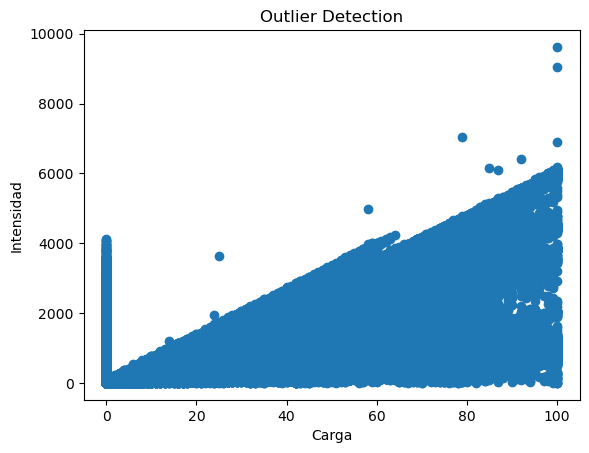

In [53]:
plt.scatter(x=data['carga'], y=data['intensidad'])
plt.title("Outlier Detection")
plt.xlabel('Carga')
plt.ylabel('Intensidad')
plt.show()